# Hackathon 7

Written by Eleanor Quint

Topics:
- Techniques for dimension expansion
    - Transpose convolutions
    - Sub-pixel convolutions
    - ProgressiveGAN upscaling
- Autoencoding
    - Sparse autoencoders
    - De-noising autoencoders

This is all setup in a IPython notebook so you can run any code you want to experiment with. Feel free to edit any cell, or add some to run your own code.

In [1]:
# We'll start with our library imports...
from __future__ import print_function

import numpy as np                 # to use numpy arrays
import tensorflow as tf            # to specify and run computation graphs
import tensorflow_datasets as tfds # to load training data
import matplotlib.pyplot as plt    # to visualize data and draw plots
from tqdm import tqdm              # to track progress of loops

In [2]:
# Let's use the code from Hack2 to load MNIST
ds = tfds.load('mnist', shuffle_files=True) # this loads a dict with the datasets

# We can create an iterator from each dataset
# This one iterates through the train data, shuffling and minibatching by 32
train_ds = ds['train'].shuffle(1024).batch(32)

### Techniques for dimension expansion

Generally, in the classifiers we've used so far, we compress high dimensional representations into lower dimensional ones. Now, we're going to study ways of going from lower dimensional to higher. For this, we're going to define a function `upscale_block` which makes the representation larger, in three different ways.

#### Transpose convolutions

Although we can upscale unstructured data very easily with a larger dense layer, images are less straightforward to upscale. As the upscaling companion to downscaling convolutions, we can learn to increase the size of images with transpose convolutions. They are sometimes called "deconvolutions" because they're the inverse operation of the convolution, but it is actually the transpose (gradient) of a convolution rather than an actual deconvolution. Transpose convolutions are implemented by [tf.keras.layers.Conv2DTranspose
](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose).

In [3]:
def upscale_block(filters, kernel_size=3, scale=2, activation=tf.nn.elu):
    """conv2d_transpose"""
    return tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=(scale, scale), padding='same', activation=activation)

upscale_op = upscale_block(64)
for batch in train_ds:
    img = tf.cast(batch['image'], tf.float32)
    up_x = upscale_op(img)
    print("Original shape:", img.shape, "New shape:", up_x.shape)
    break

num_params = upscale_op.count_params()
print('Parameters: ' + str(num_params))

Original shape: (32, 28, 28, 1) New shape: (32, 56, 56, 64)
Parameters: 640


#### Sub-pixel convolutions

Another approach is called the sub-pixel convolution, which does a regular convolution with many channels, and then re-orders the data into the height and width dimensions from the channels dimension. For some intuition, a graphic:

<img src="https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/03a5b2aac53443e6078f0f63b35d4f95d6d54c5d/2-Figure1-1.png">

(Image sourced from [Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network](https://arxiv.org/abs/1609.05158))

In [4]:
def upscale_block(filters, kernel_size=3, scale=2, activation=tf.nn.elu):
    """[Sub-Pixel Convolution](https://arxiv.org/abs/1609.05158)"""
    # Increase the number of channels to the number of channels times the scale squared
    conv = tf.keras.layers.Conv2D(filters * (scale ** 2), (kernel_size, kernel_size), activation=activation, padding='same')
    # Rearrange blocks of (1,1,scale**2) pixels into (scale,scale,1) pixels
    rearrange = tf.keras.layers.Lambda(lambda x: tf.nn.depth_to_space(x, scale))
    return tf.keras.Sequential([conv, rearrange])
    
upscale_op = upscale_block(64)
for batch in train_ds:
    img = tf.cast(batch['image'], tf.float32)
    up_x = upscale_op(img)
    print("Original shape:", img.shape, "New shape:", up_x.shape)
    break

num_params = upscale_op.count_params()
print('Parameters: ' + str(num_params))

Original shape: (32, 28, 28, 1) New shape: (32, 56, 56, 64)
Parameters: 2560


You can see that this upscale method uses more parameters than the transpose convolution. This makes it more powerful and flexible (though this isn't always desirable, e.g., if your model is overfitting).

#### ProgressiveGAN upscaling

Finally, one technique that's recently found massive success in Nvidia's ProgressiveGAN used to generate high-resolution fake celebrity faces:

<img src="https://i2.wp.com/robotnyheter.se/wp-content/uploads/2018/01/Nvidia_GAN_ansikten.jpg?w=1561" width="70%">

None of these are real photos, they've all been upsampled in the GAN framework from Gaussian noise with an architecture that uses this technique. It upscales using a classical algorithm like bilinear upscaling and then transforms the output with convolutional layers.

In [5]:
def upscale_block(filters, kernel_size=3, scale=2, activation=tf.nn.elu):
    """ similar to the upsampling used in [ProgressiveGAN](https://arxiv.org/pdf/1710.10196.pdf) """
    def upscale(x):
        n, w, h, c = x.get_shape().as_list()
        return tf.image.resize(x, [scale*h, scale*w])
    
    upscale_layer = tf.keras.layers.Lambda(upscale)
    conv = tf.keras.layers.Conv2D(filters, kernel_size, padding='same', activation=activation)
    return tf.keras.Sequential([upscale_layer, conv])

upscale_op = upscale_block(64)
for batch in train_ds:
    img = tf.cast(batch['image'], tf.float32)
    up_x = upscale_op(img)
    print("Original shape:", img.shape, "New shape:", up_x.shape)
    break

num_params = upscale_op.count_params()
print('Parameters: ' + str(num_params))

Original shape: (32, 28, 28, 1) New shape: (32, 56, 56, 64)
Parameters: 640


### Autoencoding

Generally, autoencoding is learning "a complicated identity function". This makes it a form of unsupervised learning, which doesn't require data to be explicitly labeled, but instead looks for patterns and trends in data. Typically the complication is to bottleneck the size of the representation, but can also be more varied. We'll look at code for sparse autoencoders and de-noising autoencoders.

First we'll define some preliminaries that we'll use in both architectures:

In [26]:
def upscale_block(filters, kernel_size=3, scale=2, activation=tf.nn.elu):
    """[Sub-Pixel Convolution](https://arxiv.org/abs/1609.05158)"""
    # Increase the number of channels to the number of channels times the scale squared
    conv = tf.keras.layers.Conv2D(filters * (scale**2),
                                  (kernel_size, kernel_size),
                                  activation=activation,
                                  padding='same')
    # Rearrange blocks of (1,1,scale**2) pixels into (scale,scale,1) pixels
    rearrange = tf.keras.layers.Lambda(
        lambda x: tf.nn.depth_to_space(x, scale))
    return tf.keras.Sequential([conv, rearrange])


class UpscaleBlock(tf.keras.layers.Layer):
    def __init__(self, number, kernel_size=3, activation=tf.nn.swish):
        super().__init__(name="UpscaleBlock" + str(number))
        self.activation = activation
        self.kernel_size = kernel_size
        self.is_built = False

    def build(self, x):
        channels = x.shape.as_list()[-1]
        filters = channels // 2

        bn1 = tf.keras.layers.BatchNormalization()
        conv1 = upscale_block(filters)
        bn2 = tf.keras.layers.BatchNormalization()
        conv2 = tf.keras.layers.Conv2D(filters,
                                       self.kernel_size,
                                       padding='same')
        self.main_network = [self.activation, bn1, conv1, self.activation, bn2, conv2]

        self.skip_connection = upscale_block(filters)
        self.se_activate = SqueezeExcite(filters)
        self.is_built = True

    def __call__(self, input_):
        if not self.is_built:
            self.build(input_)
        x = input_
        for layer in self.main_network:
            x = layer(x)
        output = x
        skip = self.skip_connection(input_)
        return skip + 0.1 * output


class FactorizedReduce(tf.Module):
    """Downscale version of the sub-pixel convolution which re-arranges pixels"""
    def __init__(self, channels):
        super(FactorizedReduce, self).__init__()
        assert channels % 2 == 0
        self.conv_1 = tf.keras.layers.Conv2D(channels // 4, 1, strides=2)
        self.conv_2 = tf.keras.layers.Conv2D(channels // 4, 1, strides=2)
        self.conv_3 = tf.keras.layers.Conv2D(channels // 4, 1, strides=2)
        self.conv_4 = tf.keras.layers.Conv2D(channels - 3 * (channels // 4),
                                             1,
                                             strides=2)
        self.convs = [self.conv_1, self.conv_2, self.conv_3, self.conv_4]

    def __call__(self, x):
        """Assumes NHCW data"""
        assert x.shape[2] > 1
        assert x.shape[3] > 1
        out = tf.nn.swish(x)
        conv1 = self.conv_1(out)
        conv2 = self.conv_2(out[:, :, 1:, 1:])
        conv3 = self.conv_3(out[:, :, :, 1:])
        conv4 = self.conv_4(out[:, :, 1:, :])
        out = tf.concat([conv1, conv2, conv3, conv4], -1)
        return out


class SqueezeExcite(tf.Module):
    """Activation function that performs gating"""
    def __init__(self, out_channels):
        super().__init__()
        num_hidden = max(out_channels // 16, 4)
        self.net = tf.keras.Sequential([
            tf.keras.layers.Dense(num_hidden), tf.keras.layers.Lambda(tf.nn.relu),
            tf.keras.layers.Dense(out_channels), tf.keras.layers.Lambda(tf.nn.sigmoid)
        ])

    def __call__(self, x):
        """The choice of axes assumes we're working with NHWC data"""
        ax = tf.math.reduce_mean(x, axis=[1, 2])
        # data should be flat at this po,int
        bx = self.net(ax)
        cx = tf.expand_dims(tf.expand_dims(bx, 1), 1)
        return cx * x


class DownscaleBlock(tf.keras.layers.Layer):
    def __init__(self, number, kernel_size=3, activation=tf.nn.swish):
        super().__init__(name="DownscaleBlock" + str(number))
        self.activation = activation
        self.kernel_size = kernel_size
        self.is_built = False

    def build(self, x):
        channels = x.shape.as_list()[-1]
        filters = channels * 2

        bn1 = tf.keras.layers.BatchNormalization()
        conv1 = tf.keras.layers.Conv2D(filters,
                                       self.kernel_size,
                                       strides=2,
                                       padding='same')
        bn2 = tf.keras.layers.BatchNormalization()
        conv2 = tf.keras.layers.Conv2D(filters,
                                       self.kernel_size,
                                       padding='same')
        self.main_network = [self.activation, bn1, conv1, self.activation, bn2, conv2]

        self.skip_connection = FactorizedReduce(filters)
        self.se_activate = SqueezeExcite(filters)
        self.is_built = True

    def __call__(self, input_):
        if not self.is_built:
            self.build(input_)
        x = input_
        for layer in self.main_network:
            x = layer(x)
        output = x
        skip = self.skip_connection(input_)
        return skip + 0.1 * output


encoder_network = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same',
                           activation=tf.nn.swish),  #28,28,16
    DownscaleBlock(1),  # 14,14,32
    DownscaleBlock(2),  # 7,7,64
    tf.keras.layers.Conv2D(64, 3, padding='same',
                           activation=tf.nn.swish),  # 7,7,64
    tf.keras.layers.Conv2D(16, 3, padding='same',
                           activation=tf.nn.swish),  # 7,7,16
    tf.keras.layers.Conv2D(1, 3, padding='same'),  # 7,7,4
])

decoder_network = tf.keras.Sequential([
    tf.keras.layers.Conv2D(4, 3, padding='same',
                           activation=tf.nn.swish),  # 7,7,4
    tf.keras.layers.Conv2D(16, 3, padding='same',
                           activation=tf.nn.swish),  # 7,7,16
    tf.keras.layers.Conv2D(64, 3, padding='same',
                           activation=tf.nn.swish),  # 7,7,64
    UpscaleBlock(1),  # 14,14,32
    UpscaleBlock(2),  # 28,28,16
    tf.keras.layers.Conv2D(4, 3, padding='same',
                           activation=tf.nn.swish),  #28,28,4
    tf.keras.layers.Conv2D(1, 3, padding='same'),  #28,28,16
])

In [27]:
for batch in train_ds:
    x = tf.cast(batch['image'], tf.float32)
    code = encoder_network(x)
    output = decoder_network(code)
    break
print(x.shape, code.shape, output.shape)

(32, 28, 28, 1) (32, 7, 7, 1) (32, 28, 28, 1)


#### Sparse autoenoding

Although we bottleneck the representation in normal autoencoding by reducing the dimensionality, sparse autoencoders can actually increase it, but restrict it to be sparsely activated with L1 regularization using [tf.norm](https://www.tensorflow.org/api_docs/python/tf/norm) or KL-divergence. This has the effect of only having non-zero values in a few dimensions, effectively bottlenecking each representation, but giving a greater variety of dimensions to choose to be used.

In [45]:
def sparse_autoencoder_loss(x, code, x_hat, sparsity_coeff=5.):
    sparsity_loss = tf.norm(code, ord=1, axis=1)
    reconstruction_loss = tf.reduce_mean(tf.square(x_hat - x)) # Mean Square Error
    total_loss = reconstruction_loss + sparsity_coeff * sparsity_loss
    return total_loss

max_steps = 250
step = 0
optimizer = tf.keras.optimizers.Adam()
for batch in tqdm(train_ds):
    with tf.GradientTape() as tape:
        x = tf.cast(batch['image'], tf.float32)
        code = encoder_network(x)
        output = decoder_network(code)
        loss = sparse_autoencoder_loss(x, code, output)
    gradient = tape.gradient(loss, encoder_network.trainable_variables + decoder_network.trainable_variables)
    optimizer.apply_gradients(zip(gradient, encoder_network.trainable_variables + decoder_network.trainable_variables))
    step += 1
    if step > max_steps:
        break

 13%|█▎        | 250/1875 [01:03<06:55,  3.91it/s]


In [46]:
# Show a code (which should be pretty sparse)
print(code[0])

tf.Tensor(
[[[ 1.4908686e-01]
  [ 4.2339283e-01]
  [ 9.4308460e-01]
  [-2.1568465e+00]
  [-1.8790067e+00]
  [-3.3020542e+00]
  [ 7.0723665e-01]]

 [[-1.0250514e+00]
  [-1.4052591e+00]
  [ 3.2976835e+00]
  [ 4.0087171e+00]
  [ 5.8101668e+00]
  [ 7.7373619e+00]
  [ 3.4203649e+00]]

 [[-8.2330769e-01]
  [ 1.8156372e+00]
  [ 1.9981045e+00]
  [-6.8335767e+00]
  [-9.0412722e+00]
  [-1.3096324e+01]
  [-1.0754415e+01]]

 [[ 2.9980594e-01]
  [-3.8292920e-03]
  [-1.4927105e+01]
  [-8.2689447e+00]
  [-2.1763744e+00]
  [-4.2708516e+00]
  [-9.8600435e+00]]

 [[-1.2850415e+00]
  [-5.4875135e+00]
  [ 2.7838287e+00]
  [-9.3007135e+00]
  [-5.9968286e+00]
  [ 5.6513939e+00]
  [ 6.7475283e-01]]

 [[ 1.0874690e+00]
  [-7.9813399e+00]
  [-8.1224051e+00]
  [-1.0932647e+01]
  [-2.8595920e+00]
  [ 6.9433439e-01]
  [-9.2574632e-01]]

 [[-2.0320784e-01]
  [ 1.8417556e+00]
  [-6.8605304e-01]
  [-2.8115833e-01]
  [ 3.6600363e-01]
  [-1.0034875e+00]
  [ 6.3364446e-01]]], shape=(7, 7, 1), dtype=float32)


Original and Reconstruction


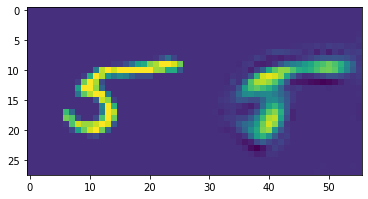

In [48]:
# Show reconstruction
# This will perform much better with more training and hyperparameter tuning
print("Original and Reconstruction")
side_by_side = tf.concat([x[0], output[0]], 1).numpy()
plt.imshow(side_by_side)

#### Denoising Autoencoder

Another way to force the an autoencoder to learn the features of data is to force it to map noisy, corrupted versions of the data back to the original. This is usually accomplished by manually adding noice (e.g., Gaussian), but may also be useful in real world settings.

In [55]:
NOISE_COEFF = 10.

def autoencoder_loss(x, x_hat):
    reconstruction_loss = tf.reduce_mean(tf.square(x_hat - x)) # Mean Square Error
    total_loss = reconstruction_loss
    return total_loss

max_steps = 250
step = 0
optimizer = tf.keras.optimizers.Adam()
for batch in tqdm(train_ds):
    with tf.GradientTape() as tape:
        x = tf.cast(batch['image'], tf.float32)
        code = encoder_network(x + tf.random.normal(x.shape))
        output = decoder_network(code)
        loss = autoencoder_loss(x, output)
    gradient = tape.gradient(loss, encoder_network.trainable_variables + decoder_network.trainable_variables)
    optimizer.apply_gradients(zip(gradient, encoder_network.trainable_variables + decoder_network.trainable_variables))
    step += 1
    if step > max_steps:
        break

 13%|█▎        | 250/1875 [01:09<07:29,  3.62it/s]


In [56]:
# Show a code (which should be pretty sparse)
print(code[0])

tf.Tensor(
[[[  2.211234 ]
  [  7.521559 ]
  [  8.363447 ]
  [  3.909775 ]
  [ -4.176254 ]
  [ -7.194827 ]
  [  0.7633354]]

 [[ -4.698588 ]
  [ -4.585447 ]
  [-13.215098 ]
  [-24.94045  ]
  [-18.87241  ]
  [ -6.911929 ]
  [ 11.298568 ]]

 [[  3.557348 ]
  [ -4.358646 ]
  [-16.024612 ]
  [ -2.2225645]
  [-27.036407 ]
  [-32.0292   ]
  [  2.2061718]]

 [[ -5.4242783]
  [  1.7809695]
  [-17.733469 ]
  [-37.680603 ]
  [-15.982113 ]
  [ -2.2150962]
  [  2.2674172]]

 [[  2.9063895]
  [  2.2730253]
  [ -1.3933939]
  [-15.200351 ]
  [-42.154182 ]
  [-14.424747 ]
  [  9.177154 ]]

 [[ -2.0921323]
  [-20.077364 ]
  [-15.209964 ]
  [-13.694405 ]
  [-27.923115 ]
  [-14.100279 ]
  [  3.0598977]]

 [[  2.0658998]
  [-13.007997 ]
  [-32.147427 ]
  [-28.386297 ]
  [  1.5882217]
  [  4.4024343]
  [ -6.3736825]]], shape=(7, 7, 1), dtype=float32)


Original and Reconstruction


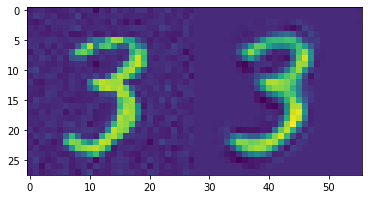

In [57]:
# Show reconstruction
# This will perform much better with more training and hyperparameter tuning
print("Original and Reconstruction")
side_by_side = tf.concat([x[0] + NOISE_COEFF * tf.random.normal(x[0].shape), output[0]], 1).numpy()
plt.imshow(side_by_side)

### Homework

Try out the autoencoder architecture above and test out the relationship between the mean squared error and the size of the latent variable (e.g., the (7,7,1) shape used above) is using the above architecture on MNIST after some training. Try 2 or 3 code sizes (or more if you like) and report the parameters of a best fit line 

### Coda

#### [Progressive GAN latent space interpolation on Youtube](https://youtu.be/XOxxPcy5Gr4?t=1m48s)